In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()
from Chempy.cem_function import single_timestep_chempy

## Load the data

In [3]:
# Define elements to use:

els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements

# Load training data:
full_input = '/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Training_Data_TNG_500000_0_v2.npz'
dat1=np.load(full_input,mmap_mode='r')
full_input2 = '/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Training_Data_TNG_500000_1_v2.npz'
dat2=np.load(full_input2,mmap_mode='r')


all_els = dat1['elements']
for e in range(len(all_els)):
    assert dat1['elements'][e]==dat2['elements'][e]
    
#params = dat1['params']#[:100000]
params=np.concatenate([dat1['params'],dat2['params']])
#big_abun = dat1.f.abundances#[:100000]
big_abun=np.concatenate([dat1.f.abundances,dat2.f.abundances])

el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


## Remove any bad runs
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

good_index=np.where(np.isfinite(cut_abuns).all(axis=1))[0] # remove infinities
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>0.99)[0] # remove bad birth times
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

# Set standardization parameters
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

# Change birth-time mean/std to give t in [0,1] - we use (T-mean_T)/std_T here so this works
par_mean[-1]=min(cut_params3[:,-1])
par_std[-1]=(max(cut_params3[:,-1])-min(cut_params3[:,-1]))

# Now randomize the selection
len_filt=np.random.choice(range(len(cut_abuns3)),replace=False,size=len(cut_abuns3))

# Create randomized and standardized training data
trainX=(cut_params3[len_filt]-par_mean)/par_std
trainY=(cut_abuns3[len_filt]-ab_mean)/ab_std

# Add in T^2 term for accuracy
n_poly=2
sq_trainX=np.zeros([trainX.shape[0],trainX.shape[1]+n_poly-1])#+2])
sq_trainX[:,:trainX.shape[1]]=trainX
for i in range(n_poly-1):
    sq_trainX[:,trainX.shape[1]+i]=trainX[:,-1]**(i+2)

print('Using %d training data points for a %d->%d shape network'%(sq_trainX.shape[0],sq_trainX.shape[1],trainY.shape[1]))

Using 915956 training data points for a 7->8 shape network


In [4]:
# Load test data:
datT=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Test_Data_TNG_50000_0_v2.npz')
abunT=datT.f.abundances[:,el_indices]
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where((np.isfinite(cut_abunsT).all(axis=1)))
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T = cut_abunsT[good_indexT]
good_index2T=np.where(cut_params2T[:,-1]>0.99)
cut_params3T=cut_params2T[good_index2T]
cut_abuns3T = cut_abuns2T[good_index2T]
                     
# Standardize using same standardizations as before
testX=(cut_params3T-par_mean)/par_std
testY=(cut_abuns3T-ab_mean)/ab_std

sq_testX=np.zeros([testX.shape[0],testX.shape[1]+n_poly-1])#+2])
sq_testX[:,:testX.shape[1]]=testX
for i in range(n_poly-1):
    sq_testX[:,testX.shape[1]+i]=testX[:,-1]**(i+2)

print("Using %d test data points"%sq_testX.shape[0])

Using 45723 test data points


## Create the network in scikit-learn

In [25]:
from sklearn import cross_validation
from sklearn.neural_network import MLPRegressor

def single_regressor(neurons,el_index,epochs=1000,verbose=True):
    """Return out-of-sample score for a given number of neurons for one element"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=epochs,learning_rate='adaptive',tol=1e-13,
                       hidden_layer_sizes=(neurons,),activation='tanh',verbose=verbose,
                      shuffle=True,early_stopping=True)#,learning_rate_init=0.1)

    model.fit(sq_trainX,trainY[:,el_index])

    model_pred=model.predict(sq_testX)
    score = np.mean((model_pred-testY[:,el_index])**2.)
    diff = np.abs(testY[:,el_index]-model_pred)
    w0,w1=model.coefs_
    b0,b1=model.intercepts_
    return score,diff,[w0,w1,b0,b1]

def all_regressor(neurons,epochs=1000,verbose=True):
    """Return out-of-sample score for a given number of neurons for all elements"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=epochs,learning_rate='adaptive',tol=1e-13,
                       hidden_layer_sizes=(neurons,),activation='tanh',verbose=verbose,
                      shuffle=True,early_stopping=True)#,learning_rate_init=0.1)

    model.fit(sq_trainX,trainY)

    model_pred=model.predict(sq_testX)
    scores = np.mean((model_pred-testY)**2.,axis=0)
    diffs = np.abs(testY-model_pred)
    w0,w1=model.coefs_
    b0,b1=model.intercepts_
    return scores,diffs,[w0,w1,b0,b1]


## Run single neuron nets for various $n_\mathrm{neuron}$

In [26]:
def neural_run(nn):
    print("Running for %d neurons"%nn)
    return single_regressor(nn,0)[0]
import multiprocessing as mp
import tqdm
p=mp.Pool()
all_neurons = np.arange(5,85,5)
neuron_scores=list(tqdm.tqdm(p.imap(neural_run,all_neurons),total=len(all_neurons)))

  0%|          | 0/16 [00:00<?, ?it/s]

Running for 15 neurons
Running for 5 neurons
Running for 10 neurons
Running for 20 neurons
Running for 40 neurons
Running for 25 neurons
Running for 35 neurons
Running for 30 neurons
Running for 50 neurons
Running for 65 neurons
Running for 55 neurons
Running for 70 neurons
Running for 60 neurons
Running for 80 neurons
Running for 75 neurons
Running for 45 neurons
Iteration 1, loss = 0.03215177
Validation score: 0.978065
Iteration 1, loss = 0.05389334
Validation score: 0.986119
Iteration 1, loss = 0.03748812
Validation score: 0.990729
Iteration 1, loss = 0.01665382
Iteration 1, loss = 0.03162182
Validation score: 0.993277
Validation score: 0.991224
Iteration 1, loss = 0.02874065
Validation score: 0.991727
Iteration 1, loss = 0.01268466
Validation score: 0.994404
Iteration 1, loss = 0.01536259
Validation score: 0.993747
Iteration 1, loss = 0.01446265
Validation score: 0.993614
Iteration 1, loss = 0.01410968
Validation score: 0.994575
Iteration 2, loss = 0.00774967
Validation score: 0.98

Iteration 8, loss = 0.00104256
Validation score: 0.998167
Iteration 10, loss = 0.00091829
Iteration 10, loss = 0.00116938
Validation score: 0.998060
Validation score: 0.998436
Iteration 15, loss = 0.00425142
Validation score: 0.991534
Iteration 7, loss = 0.00096251
Validation score: 0.998501
Iteration 8, loss = 0.00103830
Validation score: 0.998351
Iteration 7, loss = 0.00096322
Iteration 8, loss = 0.00117560
Validation score: 0.998416
Validation score: 0.997872
Iteration 7, loss = 0.00107290
Validation score: 0.998207
Iteration 14, loss = 0.00265521
Validation score: 0.994791
Iteration 12, loss = 0.00153604
Validation score: 0.997175
Iteration 12, loss = 0.00126423
Validation score: 0.997714
Iteration 11, loss = 0.00123421
Validation score: 0.997714
Iteration 7, loss = 0.00098777
Validation score: 0.998530
Iteration 16, loss = 0.00424579
Validation score: 0.991480
Iteration 11, loss = 0.00089453
Validation score: 0.998506
Iteration 11, loss = 0.00114816
Validation score: 0.997985
Iter

  6%|▋         | 1/16 [03:30<52:37, 210.48s/it]

Validation score: 0.997777
Iteration 9, loss = 0.00098968
Iteration 8, loss = 0.00091261
Validation score: 0.998471
Validation score: 0.998431
Iteration 8, loss = 0.00102638
Iteration 9, loss = 0.00113825
Validation score: 0.998078
Validation score: 0.998303
Iteration 12, loss = 0.00120898
Validation score: 0.997849
Iteration 8, loss = 0.00091679
Validation score: 0.998391
Iteration 12, loss = 0.00087548
Validation score: 0.998532
Iteration 16, loss = 0.00254427
Validation score: 0.995112
Iteration 8, loss = 0.00093664
Validation score: 0.998502
Iteration 12, loss = 0.00113012
Validation score: 0.998009
Iteration 14, loss = 0.00150921
Validation score: 0.997172
Iteration 14, loss = 0.00123684
Validation score: 0.997687
Iteration 9, loss = 0.00088743
Validation score: 0.998626
Iteration 8, loss = 0.00089855
Validation score: 0.998623
Iteration 13, loss = 0.00086170
Validation score: 0.998582
Iteration 13, loss = 0.00118597
Validation score: 0.997942
Iteration 9, loss = 0.00087179
Valida

Iteration 15, loss = 0.00077067
Validation score: 0.998835
Iteration 17, loss = 0.00082781
Validation score: 0.998729
Iteration 19, loss = 0.00094681
Validation score: 0.998294
Iteration 18, loss = 0.00074433
Validation score: 0.998776
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 29, loss = 0.00179356
Validation score: 0.996580
Iteration 17, loss = 0.00075755
Validation score: 0.998800
Iteration 25, loss = 0.00076346
Validation score: 0.998845
Iteration 15, loss = 0.00081821
Validation score: 0.998770
Iteration 22, loss = 0.00100456
Validation score: 0.998322
Iteration 14, loss = 0.00085190
Validation score: 0.998521
Iteration 30, loss = 0.00178422
Validation score: 0.996677
Iteration 18, loss = 0.00074632
Iteration 18, loss = 0.00073412
Validation score: 0.998967
Validation score: 0.998979
Iteration 18, loss = 0.00082188
Validation score: 0.998725
Iteration 16, loss = 0.00075972
Validation score: 0.998781
Iteration 20, loss = 

 12%|█▎        | 2/16 [10:02<1:01:48, 264.90s/it]

Iteration 19, loss = 0.00077503
Validation score: 0.998849
Iteration 24, loss = 0.00070801
Validation score: 0.998952
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 26, loss = 0.00087473
Validation score: 0.998539
Iteration 24, loss = 0.00078853
Iteration 27, loss = 0.00069299
Validation score: 0.998766
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Validation score: 0.999060
Iteration 18, loss = 0.00078975
Validation score: 0.998800
Iteration 27, loss = 0.00070116
Validation score: 0.999120
Iteration 20, loss = 0.00077062
Validation score: 0.998654
Iteration 27, loss = 0.00086934
Validation score: 0.998510
Iteration 28, loss = 0.00069168
Validation score: 0.999014
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 28, loss = 0.00069436
Validation score: 0.999140
Iteration 19, loss = 0.00077395
Validation score: 0.998802
Iteration 

 44%|████▍     | 7/16 [11:00<28:20, 188.93s/it]  

Iteration 27, loss = 0.00071495
Validation score: 0.998883
Iteration 28, loss = 0.00070947
Validation score: 0.998982
Iteration 29, loss = 0.00070755
Validation score: 0.998893
Iteration 30, loss = 0.00070647
Validation score: 0.998923
Iteration 31, loss = 0.00070436
Validation score: 0.998968
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


100%|██████████| 16/16 [11:12<00:00, 42.00s/it] 


In [27]:
np.savez('8element_net_variable_neurons_L2_scores_v2',neurons=all_neurons,scores=neuron_scores)

In [28]:
d=np.load('8element_net_variable_neurons_L2_scores_v2.npz')
all_neurons=d['neurons']
neuron_scores=d['scores']

(0.0004, 0.1)

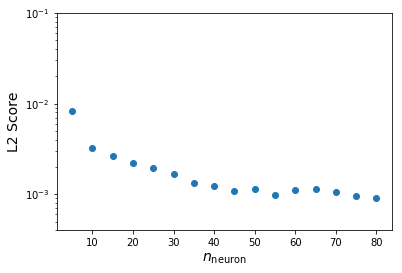

In [29]:
plt.scatter(all_neurons,neuron_scores);plt.ylabel('L2 Score',fontsize=14);
plt.xlabel(r'$n_\mathrm{neuron}$',fontsize=14);
plt.yscale('log')
plt.ylim([4e-4,1e-1])

## Now train networks in parallel using $n_\mathrm{neuron}=40$:

In [6]:
neurons=40
def mp_run(el_i):
    print("Running net %d of %d"%(int(el_i)+1,len(els)))
    output = single_regressor(neurons,int(el_i),epochs=3000)
    return output

In [7]:
import multiprocessing as mp
p=mp.Pool()
import tqdm
output=list(tqdm.tqdm(p.imap(mp_run,range(len(els))),total=len(els)))

  0%|          | 0/8 [00:00<?, ?it/s]

Running net 5 of 8
Running net 3 of 8
Running net 7 of 8
Running net 6 of 8
Running net 4 of 8
Running net 2 of 8
Running net 1 of 8
Running net 8 of 8
Iteration 1, loss = 0.01139359
Validation score: 0.997782
Iteration 1, loss = 0.01802665
Iteration 1, loss = 0.01309980
Validation score: 0.992921
Iteration 1, loss = 0.01135012
Validation score: 0.994101
Validation score: 0.998138
Iteration 1, loss = 0.01394070
Validation score: 0.996866
Iteration 1, loss = 0.01099778
Validation score: 0.997436
Iteration 1, loss = 0.02926639
Validation score: 0.988920
Iteration 1, loss = 0.01714165
Validation score: 0.993899
Iteration 2, loss = 0.00247555
Validation score: 0.996722
Iteration 2, loss = 0.00096870
Validation score: 0.998515
Iteration 2, loss = 0.00073066
Validation score: 0.998997
Iteration 2, loss = 0.00224023
Validation score: 0.996758
Iteration 2, loss = 0.00108689
Validation score: 0.998382
Iteration 2, loss = 0.00119209
Validation score: 0.998164
Iteration 2, loss = 0.00441299
Valid

Validation score: 0.998687
Iteration 18, loss = 0.00049517
Validation score: 0.998958
Iteration 19, loss = 0.00029244
Validation score: 0.999515
Iteration 18, loss = 0.00040089
Iteration 18, loss = 0.00049945
Validation score: 0.999377
Validation score: 0.999180
Iteration 18, loss = 0.00081109
Validation score: 0.998848
Iteration 18, loss = 0.00174542
Validation score: 0.997268
Iteration 18, loss = 0.00084111
Validation score: 0.998526
Iteration 19, loss = 0.00086291
Validation score: 0.998539
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 20, loss = 0.00029126
Validation score: 0.999522
Iteration 19, loss = 0.00049298
Validation score: 0.999151
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 19, loss = 0.00040036
Validation score: 0.999351
Iteration 19, loss = 0.00080632
Validation score: 0.998885
Iteration 19, loss = 0.00049529
Validation score: 0.999193
Iteration 19, loss

 12%|█▎        | 1/8 [02:06<14:43, 126.28s/it]

Iteration 24, loss = 0.00047201
Validation score: 0.999266
Iteration 26, loss = 0.00028334
Validation score: 0.999603
Iteration 25, loss = 0.00046974
Validation score: 0.999288
Iteration 27, loss = 0.00028271
Validation score: 0.999542
Iteration 26, loss = 0.00046653
Validation score: 0.999301
Iteration 28, loss = 0.00028094
Validation score: 0.999558
Iteration 27, loss = 0.00046252
Validation score: 0.999252
Iteration 29, loss = 0.00028113
Validation score: 0.999602
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


 75%|███████▌  | 6/8 [02:16<02:57, 88.99s/it] 

Iteration 28, loss = 0.00046079
Validation score: 0.999283
Iteration 29, loss = 0.00045824
Validation score: 0.999279
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


100%|██████████| 8/8 [02:19<00:00, 17.46s/it]


In [8]:
all_scores = np.zeros(len(els))
all_diffs = np.zeros([len(els),len(testY)])
coeffs=[]
for el_i in range(len(els)):
    all_scores[el_i],all_diffs[el_i],co=output[el_i]
    coeffs.append(co)

In [9]:
w0=np.hstack([co[0] for co in coeffs])
b0=np.hstack([co[2] for co in coeffs])
b1=np.hstack([co[3] for co in coeffs])

## Read in w1 vector into sparse structure
w1=np.zeros([w0.shape[1],b1.shape[0]])
assert neurons==w0.shape[1]/len(coeffs)
for i in range(len(coeffs)):
    w1[int(neurons*i):int(neurons*(i+1)),i]=coeffs[i][1][:,0]
    


In [10]:
def stacked_net_output(in_par):
    l1=np.matmul(in_par,w0)+b0
    return np.matmul(np.tanh(l1),w1)+b1

In [11]:
# Save output
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/stacked_8_element_net_v2.npz',w0=w0,w1=w1,b0=b0,b1=b1,
         in_mean=par_mean,in_std=par_std,out_mean=ab_mean,out_std=ab_std,
         activation='tanh',neurons=neurons)

In [12]:
# Reload data
dat=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/stacked_8_element_net_v2.npz')
w0=dat['w0'];w1=dat['w1'];b0=dat['b0'];b1=dat['b1']

In [13]:
l1_err = np.abs(stacked_net_output(sq_testX)-testY)

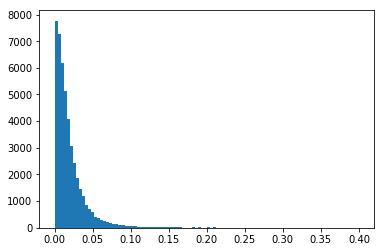

In [14]:
plt.hist(l1_err[:,2],range=[0,.4],bins=100);

## Run for all networks together:

In [15]:
comb_scores,comb_diffs,_ = all_regressor(40,epochs=3000)

Iteration 1, loss = 0.02662285
Validation score: 0.991793
Iteration 2, loss = 0.00304556
Validation score: 0.995640
Iteration 3, loss = 0.00223326
Validation score: 0.996447
Iteration 4, loss = 0.00201355
Validation score: 0.996772
Iteration 5, loss = 0.00189183
Validation score: 0.996984
Iteration 6, loss = 0.00180401
Validation score: 0.997195
Iteration 7, loss = 0.00175631
Validation score: 0.997333
Iteration 8, loss = 0.00172259
Validation score: 0.997371
Iteration 9, loss = 0.00169681
Validation score: 0.997394
Iteration 10, loss = 0.00167808
Validation score: 0.997448
Iteration 11, loss = 0.00166129
Validation score: 0.997516
Iteration 12, loss = 0.00164695
Validation score: 0.997581
Iteration 13, loss = 0.00163568
Validation score: 0.997596
Iteration 14, loss = 0.00162481
Validation score: 0.997658
Iteration 15, loss = 0.00161501
Validation score: 0.997641
Iteration 16, loss = 0.00160784
Validation score: 0.997654
Iteration 17, loss = 0.00160143
Validation score: 0.997720
Iterat

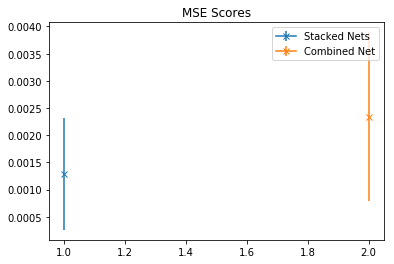

In [16]:
plt.errorbar(1,np.mean(all_scores),yerr=np.std(all_scores),marker='x',label='Stacked Nets')
plt.errorbar(2,np.mean(comb_scores),yerr=np.std(comb_scores),marker='x',label='Combined Net')
plt.legend();plt.title('MSE Scores');

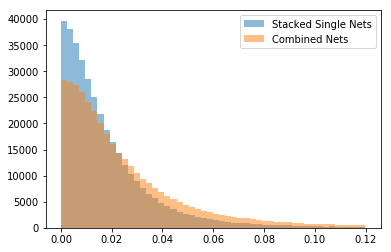

In [17]:
plt.hist(all_diffs.ravel(),range=[0,np.percentile(all_diffs.ravel(),99)],alpha=0.5,bins=50,label='Stacked Single Nets');
plt.hist(comb_diffs.ravel(),range=[0,np.percentile(all_diffs.ravel(),99)],alpha=0.5,bins=50,label='Combined Nets');
plt.legend();

In [18]:
## Compute L1 differences for combined and stacked nets (with correct normalizations)
real_all_diffs = np.asarray([ad*ab_std for ad in all_diffs.T])
real_comb_diffs = np.asarray([cd*ab_std for cd in comb_diffs])

In [19]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Training_plot_data_v2.npz',
        real_all_diffs=real_all_diffs,
        real_comb_diffs=real_comb_diffs,
        els=els)

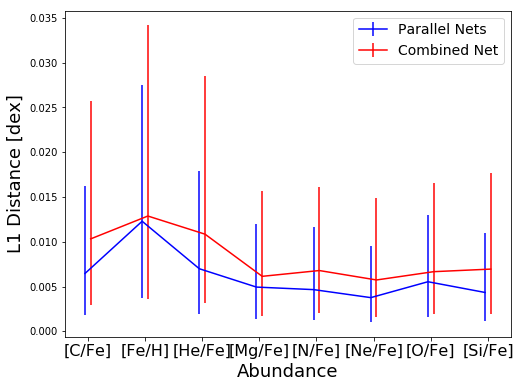

In [20]:
def percs(data,axis=0):
    percs=np.percentile(data,[15.865,50.,100.-15.865],axis=axis)
    return percs[1],percs[1]-percs[0],percs[2]-percs[1]
all_percs=percs(real_all_diffs)
comb_percs=percs(real_comb_diffs)


plt.figure(figsize=(8,6))
plt.errorbar(np.arange(len(els))-0.05,all_percs[0],
             yerr=[all_percs[1],all_percs[2]],label='Parallel Nets',c='b');
plt.errorbar(np.arange(len(els))+0.05,comb_percs[0],
             yerr=[comb_percs[1],comb_percs[2]],label='Combined Net',c='r');FS=18
plt.legend(fontsize=14);plt.ylabel('L1 Distance [dex]',fontsize=FS);plt.xlabel('Abundance',fontsize=FS)

names = []
for el in els:
    if el!='Fe':
        names.append('[%s/Fe]'%el)
    else:
        names.append('[Fe/H]')

plt.xticks(range(8),names,fontsize=16);
plt.savefig('Plots_New/L1_Element_Error_v2.pdf',bbox_inches='tight')

In [21]:
p1,p2,p3=np.percentile(real_all_diffs,[15.865,50.,100-17.865])

In [22]:
print(r'$%.3f_{-%.3f}^{+%.3f}$'%(p2,p2-p1,p3-p2))

$0.006_{-0.004}^{+0.008}$


In [23]:
print("Single Stacked Nets",np.mean(real_all_diffs).round(3),np.std(real_all_diffs).round(3))

Single Stacked Nets 0.009 0.015


In [24]:
print("Combined Nets",np.mean(real_comb_diffs).round(3),np.std(real_comb_diffs).round(3))

Combined Nets 0.013 0.02


### So the single nets seem to perform better here.

## Now access the convergence across parameter space:

#### Using mean L1 error here:

In [30]:
train_par = cut_params3
test_par=cut_params3T
stacked_pred =stacked_net_output(sq_testX)
stacked_diff = np.mean(np.abs((stacked_pred-testY)*ab_std),axis=1) # destandardize here

<Figure size 432x288 with 0 Axes>

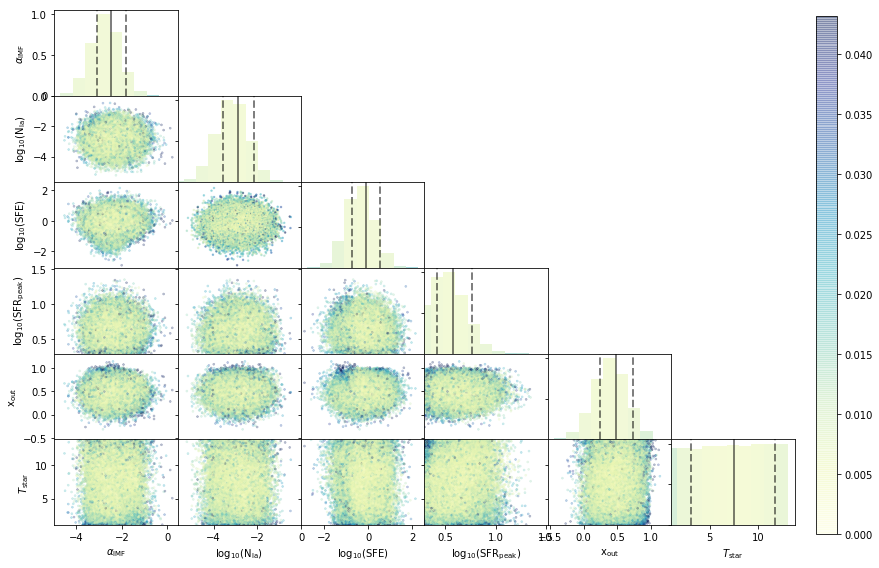

In [31]:
data_tr = train_par
data_v = test_par
param_error = stacked_diff

# Initialize plot
plt.clf()
text_size = 12

#plt.rc('text', usetex=False)
#plt.rc('font', family='sans-serif')

#plt.rc('font', family='serif',size = text_size)
#plt.rc('xtick', labelsize=text_size)
#plt.rc('ytick', labelsize=text_size)
#plt.rc('axes', labelsize=text_size, lw=1.0)
#plt.rc('lines', linewidth = 1)
#plt.rcParams['ytick.major.pad']='8'
#plt.rcParams['text.latex.preamble']=[r"\usepackage{libertine}"]
#params = {'text.usetex' : True,
#      'font.family' : 'libertine',
#      'text.latex.unicode': True,
#      }
#plt.rcParams.update(params)
parameter_names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}(\mathrm{N_{Ia}})$',
               r'$\log_{10}(\mathrm{SFE})$',
               r'$\log_{10}(\mathrm{SFR_{peak}})$',r'$\mathrm{x}_\mathrm{out}$',r'$T_\mathrm{star}$']


# Plot settings
fig,axes = plt.subplots(nrows = 6, ncols = 6,figsize=(14.69,8.0))#,dpi=300)
alpha = 0.5
lw=2 # Linewidth
left = 0.1 # Left side of subplots
right = 0.8 # Right side
bottom = 0.075
top = 0.97
wspace = 0.0 # blankspace width between subplots
hspace = 0.0 # blankspace height between subplots
color_max = np.percentile(param_error,99.)#0.05#a.color_max
plt.subplots_adjust(left=left,bottom=bottom,right=right,top=top,wspace=wspace,hspace=hspace)

cmap= cm.YlGnBu

# Create plot
for i in range(6):
    for j in range(6):
        axes[i,j].locator_params(nbins=4)
        if j==1:
            axes[i,j].locator_params(nbins=4)
        if i==j:
            counts,edges = np.histogram(np.asarray(data_v[:,j]),bins=10)
            max_count = float(np.max(counts))
            counts = np.divide(counts,max_count)
            median = np.zeros(len(edges)-1)
            for k in range(len(edges)-1):
                choice = np.logical_and(np.greater(data_v[:,j],edges[k]),np.less(data_v[:,j],edges[k+1]))
                error=np.extract(choice,param_error)
                if len(error) != 0:
                    median[k] = np.median(error)
            colors = cmap(median/color_max)
            axes[i,j].bar(x = edges[:-1], height=counts, width = edges[1]-edges[0],
                                color=colors,alpha=alpha, linewidth=0,rasterized=True)
            axes[i,j].set_xlim(min(data_v[:,j]),max(data_v[:,j]))
            axes[i,j].set_ylim(0,1.05)
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            axes[i,j].vlines(np.percentile(data_v[:,j],15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],100-15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],50),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw)
        if i>j:
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            P1 = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='x',alpha=0.3,
                                    c=param_error,vmin=0,vmax=color_max,cmap=cmap,s=3,rasterized=True)
            #P2 = axes[i,j].scatter(data_tr[:,j],data_tr[:,i],c='k',marker='+',s=80)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
        if j>i:
            axes[i,j].axis('off')
        if i == 5:
            axes[i,j].set_xlabel(parameter_names[j])
        if j ==0:
            axes[i,j].set_ylabel(parameter_names[i])
        if i==2 and j == 1:
            cplot = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='.',alpha=0.3,
                                                c=param_error,vmin=0,vmax=color_max,
                                                cmap=cmap,s=3,rasterized=True)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
cax=fig.add_axes([0.82,0.06,0.02,0.9]);
plt.colorbar(cplot,cax=cax);

#plt.savefig('Plots/Network_Error_Param_Space.pdf',bbox_inches='tight')

plt.show();


In [33]:
fig.savefig('Plots_New/Network_Error_Param_Space_v2.png',dpi=300)#,bbox_inches='tight')#,dpi=50)